# Capstone Project
- Ruben Holthuijsen
- Sander van Swieten
- Victor de Sousa Gama
- Vince van Doorn
- Kevin Hartman

# All imports needed to run code

In [27]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import get_args
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Load the clinical data file and keep only the necessary columns

In [28]:
# import pandas as pd
# import os

dataPath = '../Data'
dataFile = os.path.join(dataPath, '8162d394-8b64-4da2-9f5b-d164c54b9608', 'nationwidechildrens.org_clinical_patient_brca.txt')

df = pd.read_csv(filepath_or_buffer=dataFile, sep='\t', skiprows=[1,2])
# Note: The clinical file has a three-line header; the second and third lines are not needed for our pusposes
df[['bcr_patient_uuid', 'er_status_by_ihc', 'pr_status_by_ihc', 'her2_status_by_ihc']] # Expected output: 1097 rows

,bcr_patient_uuid,er_status_by_ihc,pr_status_by_ihc,her2_status_by_ihc
0,6E7D5EC6-A469-467C-B748-237353C23416,Positive,Positive,Negative
1,55262FCB-1B01-4480-B322-36570430C917,Positive,Positive,Positive
2,427D0648-3F77-4FFC-B52C-89855426D647,Positive,Positive,Indeterminate
3,C31900A4-5DCD-4022-97AC-638E86E889E4,Positive,Positive,Positive
4,6623FC5E-00BE-4476-967A-CBD55F676EA6,Positive,Positive,Equivocal
...,...,...,...,...
1092,5CD79093-1571-4F71-8136-0D84CCABDCAC,Positive,Positive,Negative
1093,F89588E9-CA73-4465-A7FB-7246EDB45E3A,Positive,Positive,Negative
1094,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,Positive,Positive,Negative
1095,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,Positive,Positive,Negative


## Determine Triple Negative status and drop indeterminable cases

In [29]:
triple_negative = (df[['er_status_by_ihc', 'pr_status_by_ihc', 'her2_status_by_ihc']] == 'Negative').all(axis=1)
any_positive = (df[['er_status_by_ihc', 'pr_status_by_ihc', 'her2_status_by_ihc']] == 'Positive').any(axis=1)
df['tnbc'] = pd.NA
df.loc[triple_negative, 'tnbc'] = True
df.loc[any_positive, 'tnbc'] = False
# df[df.isna().any(axis=1)] # Shows indeterminable cases: 118 rows x 5 columns
df.dropna(inplace=True) # Drop indeterminable cases
df['tnbc'].value_counts() # Expected tnbc values: False 863, True 116

tnbc
False    863
True     116
Name: count, dtype: int64

## Link all cases to the corresponding RNA sequencing data file using the metadata

In [30]:
# import json

with open(os.path.join(dataPath, 'metadata.cart.2025-04-01.json'), 'r') as f:
    data = json.load(f)

rna_files = {
    entity['case_id'].upper(): os.path.join(file['file_id'], file['file_name'])
    for file in data
    if 'experimental_strategy' in file and file['experimental_strategy'] == 'RNA-Seq' and 'associated_entities' in file and len(file['associated_entities']) > 0
    for entity in file['associated_entities']
} # case_id in uppercase equals df['bcr_patient_uuid']; file is found in folder with its 'file_id', under its 'file_name'
rna_files

df['file'] = df['bcr_patient_uuid'].str.upper().map(rna_files)
df['exists'] = df['file'].apply(lambda file: not pd.isna(file) and os.path.exists(os.path.join(dataPath, file)))
# df[df['exists'] == False] # Shows cases with missing RNA files: 2 rows
df = df[df['exists'] == True]
df.to_csv(os.path.join(dataPath, 'clinical.csv'), index=False)
df[['bcr_patient_uuid', 'tnbc', 'file']] # Expected output: 977 rows

,bcr_patient_uuid,tnbc,file
0,6E7D5EC6-A469-467C-B748-237353C23416,False,84225715-14a6-423c-a6d6-15558e151f56\253aa5dc-...
1,55262FCB-1B01-4480-B322-36570430C917,False,927604f9-a38e-4c3f-b50f-3e0db4daf5ec\1be6a56c-...
2,427D0648-3F77-4FFC-B52C-89855426D647,False,931442ba-af81-4b68-beca-7285fc44b1df\f2dda955-...
3,C31900A4-5DCD-4022-97AC-638E86E889E4,False,7b4d770a-2b8c-4ca5-bf51-c4745c5de39a\ae8996bd-...
4,6623FC5E-00BE-4476-967A-CBD55F676EA6,False,307261f2-f88f-4658-b6d1-98ef946148e2\75d91076-...
...,...,...,...
1092,5CD79093-1571-4F71-8136-0D84CCABDCAC,False,0a7dc8b9-4196-41d3-ada1-a50cb36bfd2b\3c9c665e-...
1093,F89588E9-CA73-4465-A7FB-7246EDB45E3A,False,e0cb738d-854a-4033-b370-79fa28d7cef8\69118aea-...
1094,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,False,e25bb12b-f88b-41c5-951e-a36d4b94008f\73e13f2d-...
1095,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,False,ee447251-5c90-426f-a0c7-bd2041189761\06a03e45-...


## Determining features

In [31]:
targetGenes = [ 'PIK3CA', 'BRCA1', 'BRCA2', 'CD274', 'TP53', 'EGFR ', 'PDCD1', 'CD8A', 'MKI67', 
                'CD8B', 'CTLA4', 'GATA3', 'PTEN', 'AR', 'CD4', 'CDK6', 'CDKN2A', 'MYC', 'AKT1', 
                'CDK4', 'ERBB2', 'FGFR2', 'CCND1', 'CDH2', 'DCLK1', 'FOXA1', 'FOXC1', 'LAG3', 
                'TACSTD2', 'TOP2A', 'TTN', 'VIM ', 'ATM', 'CD44', 'CDH1', 'EPCAM', 'IFNG', 'MTOR', 
                'PDGFRA', 'PGF', 'PGR', 'RB1', 'TGFB1', 'TGFB2', 'TGFB3', 'XBP1', 'AKT2', 'AKT3', 
                'CD14', 'CD152', 'CD3D', 'CD68', 'CD79A', 'CD86', 'CDK1', 'COL1A1', 'COL1A2', 
                'ESR1', 'FBXW7', 'FGFR1', 'FOXP3', 'IDO1', 'INPP4B', 'KRT14', 'KRT5', 'MAP3K1', 
                'MDM2', 'MUC1', 'NOTCH1', 'NOTCH2', 'NOTCH4', 'PDGFRB', 'PECAM1', 'PIK3R1', 
                'SREBF1', 'STAT1', 'VEGFA', 'VEGFB', 'VEGFC', 'VEGFD' ]

In [32]:
df = pd.read_csv('../Data/clinical.csv')

In [33]:
geneFiles = df[['file', 'tnbc', 'bcr_patient_uuid']]

In [34]:
dfPatientGenes = pd.DataFrame()
total_files = len(geneFiles)
for idx, row in geneFiles.iterrows():
    file_name = row.iloc[0]
    file_path = f"../Data/{file_name}"
    
    print(f"File {idx+1}/{total_files} - {file_name}", end="\r")
    
    dfGenes = pd.read_csv(file_path, sep='\t', skiprows=[0])
    
    # Columns may have been dropped if first line in file were columns, load data again without dropping first line
    if "gene_name" not in dfGenes.columns:
        dfGenes = pd.read_csv(file_path, sep='\t')
    
    #dfGenes
    
    #Gather all targeted genes we want with the values we want
    dfTarget = dfGenes[dfGenes['gene_name'].isin(targetGenes)][['gene_name', 'stranded_first']]

    #Transform the dfTarget to a single row dataframe with all genes as columns
    dfNewGenes = dfTarget.set_index('gene_name').T.reset_index(drop=True)

    # Add tnbc status
    dfNewGenes["tnbc"] = df["tnbc"].loc[df['file'] == file_name].values

    #Add the patient uuid for reference and set it as the index
    patientID = df['bcr_patient_uuid'].loc[df['file'] == file_name]
    dfNewGenes['case_id'] = patientID.values
    
    #Concat the data to the final dataframe before saving it to a file
    dfPatientGenes = pd.concat([dfPatientGenes, dfNewGenes])
    
    
#For visualizing the result
# dfPatientGenes

In [35]:
dfPatientGenes.to_csv('../Data/patient_genes.csv', index=False)

## Load features to apply models

In [36]:
FILE_PATH = "../Data/patient_genes.csv"
df = pd.read_csv(FILE_PATH)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 79 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CD4      977 non-null    int64 
 1   BRCA1    977 non-null    int64 
 2   CD44     977 non-null    int64 
 3   CDH1     977 non-null    int64 
 4   FOXP3    977 non-null    int64 
 5   FOXC1    977 non-null    int64 
 6   FGFR2    977 non-null    int64 
 7   SREBF1   977 non-null    int64 
 8   FGFR1    977 non-null    int64 
 9   PGR      977 non-null    int64 
 10  LAG3     977 non-null    int64 
 11  ESR1     977 non-null    int64 
 12  TGFB2    977 non-null    int64 
 13  MAP3K1   977 non-null    int64 
 14  XBP1     977 non-null    int64 
 15  AKT2     977 non-null    int64 
 16  TGFB1    977 non-null    int64 
 17  CD79A    977 non-null    int64 
 18  CDK6     977 non-null    int64 
 19  GATA3    977 non-null    int64 
 20  COL1A1   977 non-null    int64 
 21  INPP4B   977 non-null    int64 
 22  FB

## Basic model implementations

### Imports

In [37]:
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from typing import get_args

### Dataset split: training and test data

In [38]:
# Constants
TNBC = "tnbc"
CASE_ID = "case_id"
RANDOM_STATE = 42

# Type annotations
Model = LogisticRegression | SVC | RandomForestClassifier


# Features: all columns except TNBC column
X = df.drop(columns=[TNBC, CASE_ID])
# Target variable
y = df[TNBC]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training size = 0.8 * 977 ≈ 781
# Test size = 0.2 * 977 ≈ 196
print(f"{X_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")


X_train.shape=(781, 77)
X_test.shape=(196, 77)
y_train.shape=(781,)
y_test.shape=(196,)


### Helper functions

In [39]:
def get_accuracy_score(y_pred):
    return accuracy_score(y_test, y_pred)

def print_evaluated_model_accuracy(y_pred) -> None:
    print(f"Accuracy: {get_accuracy_score(y_pred):.2f}")    

def print_validated_model_accuracy(model: Model, cv: int = 5) -> None:
    assert isinstance(model, Model), f"Parameter 'model' needs to be one of the following types {[type_.__name__ for type_ in get_args(Model)]}"

    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"Model validation for {type(model).__name__}:")
    print(cv_scores)
    print(f"\nMean accuracy: {cv_scores.mean():.4f}\n")

### Logistic Regression

In [49]:
# Create model
# Bumping max_iter to a higer number than the default 100, resolves the following warning
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, solver='saga', max_iter=10000)

# Train the model
logistic_regression_model.fit(X_train, y_train)

# Model predictions
y_pred_logistic_regression = logistic_regression_model.predict(X_test)

# Evaluate model
print_evaluated_model_accuracy(y_pred_logistic_regression)

Accuracy: 0.93


### SVM

In [41]:
# Create model
svm_model = SVC(random_state=RANDOM_STATE)

# Train the model
svm_model.fit(X_train, y_train)

# Model predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate model
print_evaluated_model_accuracy(y_pred_svm)

Accuracy: 0.89


### Random Forest

In [42]:
# Create model
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)

#Train the model
random_forest_model.fit(X_train, y_train)

# Model predictions
y_pred_random_forest = random_forest_model.predict(X_test)

# Evaluate
print_evaluated_model_accuracy(y_pred_random_forest)

Accuracy: 0.94


## Model basic validations

In [50]:
print_validated_model_accuracy(logistic_regression_model)

print_validated_model_accuracy(svm_model)

print_validated_model_accuracy(random_forest_model)


Model validation for LogisticRegression:
[0.92857143 0.93877551 0.94358974 0.94871795 0.91794872]

Mean accuracy: 0.9355

Model validation for SVC:
[0.88265306 0.88265306 0.88205128 0.88717949 0.87692308]

Mean accuracy: 0.8823

Model validation for RandomForestClassifier:
[0.93367347 0.92857143 0.94358974 0.93333333 0.91794872]

Mean accuracy: 0.9314



## Model Evaluation

### Get evaluation data

In [51]:
# from sklearn.metrics import classification_report, confusion_matrix

targetNames = ['nTNBC', 'TNBC']

classLG = classification_report(y_test, y_pred_logistic_regression, output_dict=True, target_names=targetNames, zero_division=0)
classSVM = classification_report(y_test, y_pred_svm, output_dict=True, target_names=targetNames, zero_division=0)
classRF  = classification_report(y_test, y_pred_random_forest , output_dict=True, target_names=targetNames, zero_division=0)

confMatrixLG = confusion_matrix(y_test, y_pred_logistic_regression)
confMatrixSVM = confusion_matrix(y_test, y_pred_svm)
confMatrixRF = confusion_matrix(y_test, y_pred_random_forest)

accuracyLG = accuracy_score(y_test, y_pred_logistic_regression);
accuracySVM = accuracy_score(y_test, y_pred_svm);
accuracyRF  = accuracy_score(y_test, y_pred_random_forest);

evalPrecision = 'precision'
evalRecall = 'recall'
evalF1score = 'f1-score'

evalTargetN = 'nTNBC'
evalTarget = 'TNBC'

models = ['Random Forest', 'Support Vector Machine' ,'Logistical Regression']
classLabels = ['Precision', 'Recall', 'F1-score']

notTNBCData = {
    'Random Forest'         : (classRF[evalTargetN][evalPrecision]*100 , classRF[evalTargetN][evalRecall]*100 , classRF[evalTargetN][evalF1score]*100 ),
    'Support Vector'        : (classSVM[evalTargetN][evalPrecision]*100, classSVM[evalTargetN][evalRecall]*100, classSVM[evalTargetN][evalF1score]*100),
    'Logistical Regression' : (classLG[evalTargetN][evalPrecision]*100, classLG[evalTargetN][evalRecall]*100, classLG[evalTargetN][evalF1score]*100)
}
TNBCData = {
    'Random Forest'      : (classRF[evalTarget][evalPrecision]*100 , classRF[evalTarget][evalRecall]*100 , classRF[evalTarget][evalF1score]*100 ),
    'Support Vector'     : (classSVM[evalTarget][evalPrecision]*100, classSVM[evalTarget][evalRecall]*100, classSVM[evalTarget][evalF1score]*100),
    'Logistical Regression' : (classLG[evalTarget][evalPrecision]*100, classLG[evalTarget][evalRecall]*100, classLG[evalTarget][evalF1score]*100),
}
accuracyData = {
    'Random Forest' : (accuracyRF*100),
    'Support Vector' : (accuracySVM*100),
    'Logistical Regression' : (accuracyLG*100)
}

### Plot the data to charts

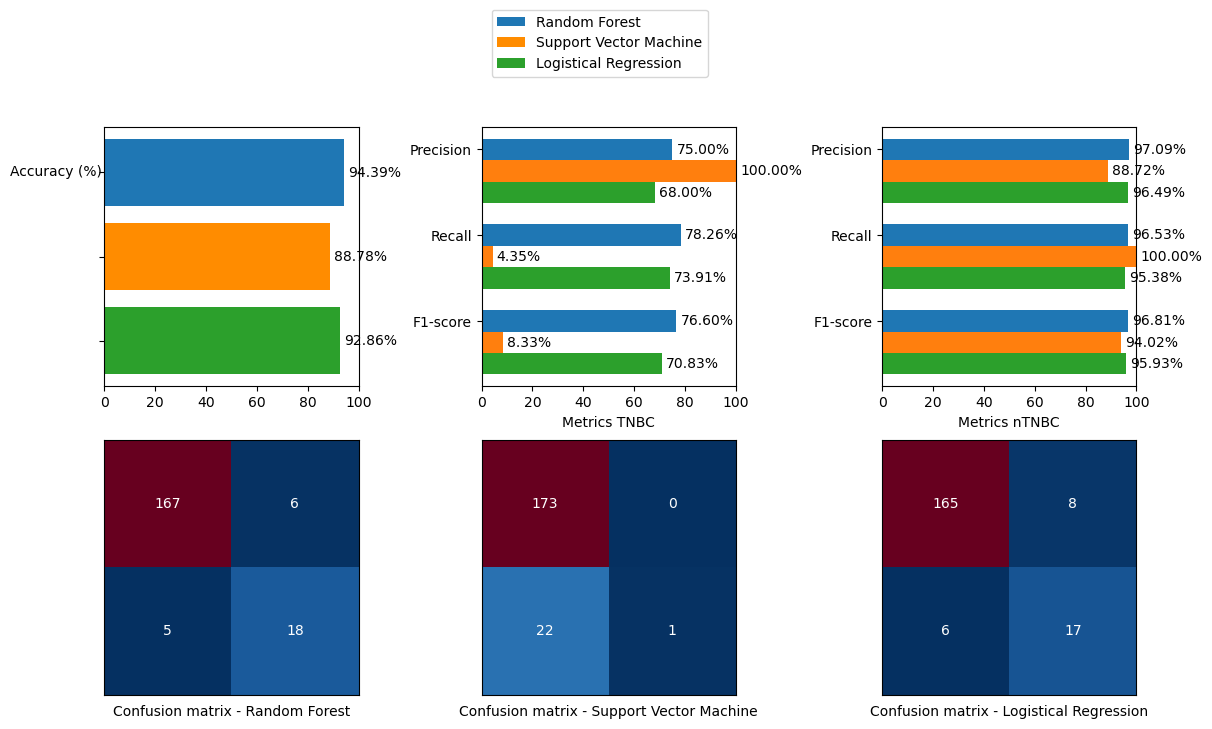

In [52]:
# import matplotlib.pyplot as plt
# import numpy as np

fig, ax = plt.subplots(nrows = 2, ncols = 3, layout='constrained', figsize=[12,6])

# == Accuracy
ax[0,0].set_xlim(0,100)

rects = ax[0,0].barh(y=accuracyData.keys(), width=accuracyData.values(), color=['#1F77B4', 'darkorange', '#2CA02C'])
ax[0,0].bar_label(rects, padding=3, fmt='%.2f%%')
ax[0,0].set_ylabel('Accuracy (%)', rotation=0, horizontalalignment='left')
ax[0,0].yaxis.set_label_coords(-0.37, 0.8)
ax[0,0].set_yticklabels('')
ax[0,0].invert_yaxis()

# == TNBC
width = 0.25
multiplier = 0
ax[0,1].set_xlim(0, 100)
y_pos = np.arange(len(models))
for attribute, measurement in TNBCData.items():
    offset = width * multiplier
    rectsTNBC = ax[0,1].barh(y_pos + offset, measurement, width, label=attribute)
    ax[0,1].bar_label(rectsTNBC, padding=3, fmt='%.2f%%')
    multiplier += 1

ax[0,1].set_yticks(y_pos)
ax[0,1].set_yticklabels(classLabels)
ax[0,1].invert_yaxis()
ax[0,1].set_xlabel('Metrics TNBC')

# == tNBC
multiplier = 0
ax[0,2].set_xlim(0, 100)
y_pos = np.arange(len(models))
for attribute, measurement in notTNBCData.items():
    offset = width * multiplier  
    rectsNTNBC = ax[0,2].barh(y_pos + offset, measurement, width, label=attribute)
    ax[0,2].bar_label(rectsNTNBC, padding=3, fmt='%.2f%%')
    multiplier += 1

ax[0,2].set_yticks(y_pos)
ax[0,2].set_yticklabels(classLabels)
ax[0,2].invert_yaxis()
ax[0,2].set_xlabel('Metrics nTNBC')

# == Three confusion matrices
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
ax[1,0].imshow(confMatrixRF, cmap='RdBu_r')
for i in range(2):
    for j in range(2):
        text = ax[1,0].text(j, i, confMatrixRF[i, j],
                       ha="center", va="center", color="white")

ax[1,0].yaxis.set_visible(False)
ax[1,0].set_xticklabels('')
ax[1,0].set_xlabel('Confusion matrix - Random Forest')
ax[1,0].tick_params(axis=u'both', which=u'both',length=0)

ax[1,1].imshow(confMatrixSVM, cmap='RdBu_r')
for i in range(2):
    for j in range(2):
        if confMatrixSVM[i, j] > 44 and confMatrixSVM[i, j] < 60:
            text = ax[1,1].text(j, i, confMatrixSVM[i, j],
                           ha="center", va="center", color="black")
        else:
            text = ax[1,1].text(j, i, confMatrixSVM[i, j],
                           ha="center", va="center", color="white")
            
ax[1,1].yaxis.set_visible(False)
ax[1,1].set_xticklabels('')
ax[1,1].set_xlabel('Confusion matrix - Support Vector Machine')
ax[1,1].tick_params(axis=u'both', which=u'both',length=0)

ax[1,2].imshow(confMatrixLG, cmap='RdBu_r')
for i in range(2):
    for j in range(2):
        text = ax[1,2].text(j, i, confMatrixLG[i, j],
                       ha="center", va="center", color="white")

ax[1,2].yaxis.set_visible(False)
ax[1,2].set_xticklabels('')
ax[1,2].set_xlabel('Confusion matrix - Logistical Regression')
ax[1,2].tick_params(axis=u'both', which=u'both',length=0)

fig.legend(handles=rects, labels=models, bbox_to_anchor=(0.09, 0.7, 0.5, 0.5))

chartsPartOne = plt.gcf()

plt.show()

### Plot the ROC Curve and Compute AUC Score

#### Get the ROC and AUC data

In [53]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import auc

## Computing ROC curve [ISBN 978-14-49-36988-0]
y_probsRF = random_forest_model.predict_proba(X_test)[:, 1]
y_probsSVM = svm_model.decision_function(X_test)
y_probsLG = logistic_regression_model.predict_proba(X_test)[:, 1]

fprRF, tprRF, thresholdsRF = roc_curve(y_test, y_probsRF)
fprSVM, tprSVM, thresholdsSVM = roc_curve(y_test, y_probsSVM)
fprLG, tprLG, thresholdsLG = roc_curve(y_test, y_probsLG)

rocAucRF = auc(fprRF, tprRF)
rocAucSVM = auc(fprSVM, tprSVM)
rocAucLG = auc(fprLG, tprLG)

rocAucData = {
    'Random Forest'          : rocAucRF*100,
    'Support Vector Machine' : rocAucSVM*100,
    'Logistical Regression'  : rocAucLG*100
}

#### Plot the data to charts

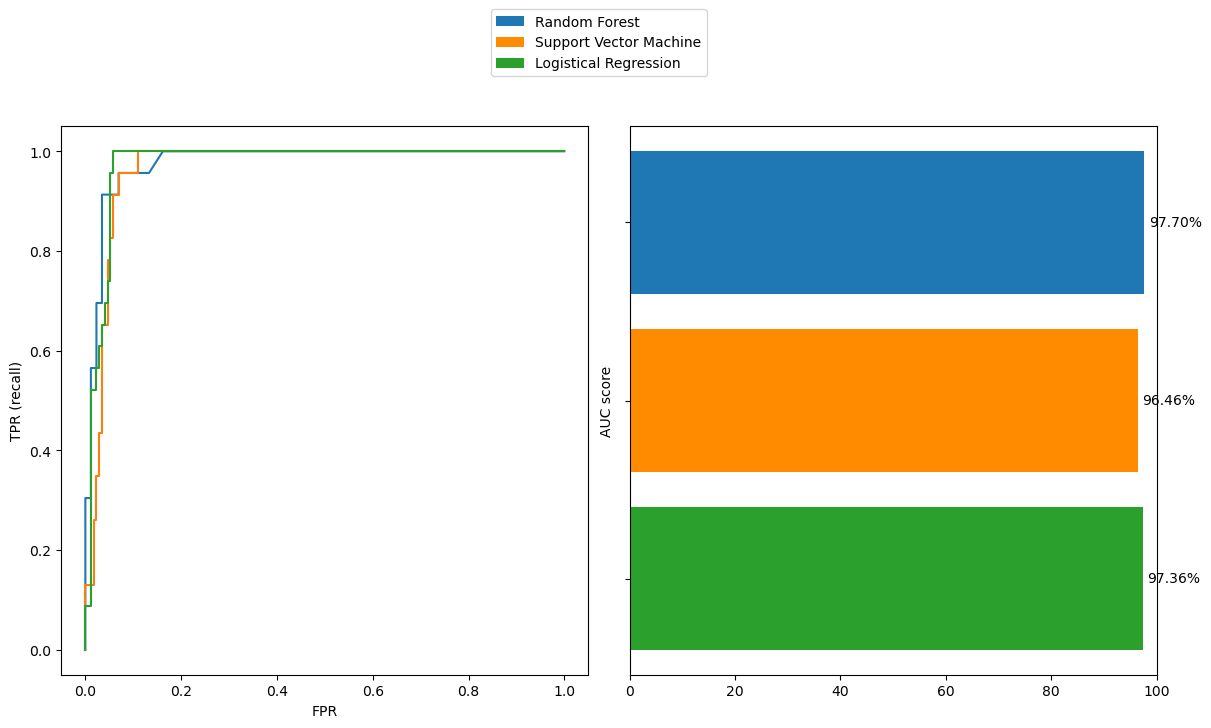

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, layout='constrained', figsize=[12,6])

## Computing ROC curve [978-14-49-36988-0]
ax[0].plot(fprRF, tprRF, label='Random Forest')
ax[0].plot(fprSVM, tprSVM, label='Support Vector Machine')
ax[0].plot(fprLG, tprLG, label='Logistical Regression')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR (recall)')

rects = ax[1].barh(y=rocAucData.keys(), width=rocAucData.values(), color=['#1F77B4', 'darkorange', '#2CA02C'])
ax[1].set_xlim(0, 100)
ax[1].bar_label(rects, padding=3, fmt='%.2f%%')
ax[1].set_ylabel('AUC score')
ax[1].set_yticklabels('')
ax[1].invert_yaxis()

fig.legend(handles=rects, labels=models, bbox_to_anchor=(0.09, 0.7, 0.5, 0.5))

chartsPartTwo = plt.gcf()

plt.show()

### Cross Model Validation

#### Get 5-Fold Cross Validation data

In [55]:
# from sklearn.model_selection import cross_val_score

cs_scores_LG  = cross_val_score(logistic_regression_model, X, y, cv=5, scoring='accuracy')
cs_scores_SVM = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
cs_scores_RF  = cross_val_score(random_forest_model, X, y, cv=5, scoring='accuracy')

fold5Data = {
    'Random Forest'          : cs_scores_RF.mean()*100,
    'Support Vector Machine' : cs_scores_SVM.mean()*100,
    'Logistical Regression'  : cs_scores_LG.mean()*100
}

#### Plot data to charts

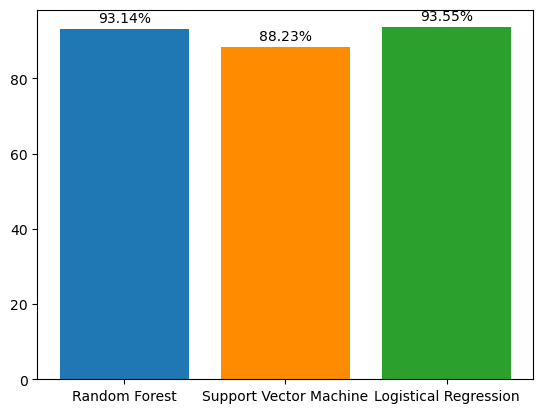

In [56]:
fig, ax = plt.subplots()

rects = ax.bar(fold5Data.keys(), fold5Data.values(), label=fold5Data.keys(), color=['#1F77B4', 'darkorange', '#2CA02C'])
ax.bar_label(rects, padding=3, fmt='%.2f%%')

plt.show()